In [1]:
#Comparing Months and Regions

In [1]:
import apache_beam

In [2]:
import os
import weatherbench2
import xarray as xr
import math
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion
from weatherbench2.evaluation import evaluate_in_memory
from weatherbench2 import config
import numpy as np
import sigkernel
import torch
from einops import rearrange
from itertools import product
import cython
import matplotlib.pyplot  as plt
import tqdm
import Functions as fu
import line_profiler

In [4]:
obs_pathlarge = 'gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-240x121_equiangular_with_poles_conservative.zarr'
observations240121 = xr.open_zarr(obs_pathlarge)
observations240121

<xarray.Dataset>
Dimensions:                                           (time: 93544,
                                                       longitude: 240,
                                                       latitude: 121, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 -90....
  * level                                             (level) int64 50 ... 1000
  * longitude                                         (longitude) float64 0.0...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(8, 240, 121), meta=np.ndarray>
    10m_v_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(8, 240, 121), meta=np.ndarray>
    10m_wind_speed                                    (time, longitude, latitude) float32 dask.array<chunksize=(8, 240, 121), meta=np.ndarray>
    2m_dewpoint_temperature                           (time, longitude, latitude) float32 dask.array<chunksize=(8, 240, 121), meta=np.ndarray>
    2m_temperature                                    (time, longitude, latitude) float32 dask.array<chunksize=(8, 240, 121), meta=np.ndarray>
    above_ground                                      (time, level, longitude, latitude) float32 dask.array<chunksize=(8, 13, 240, 121), meta=np.ndarray>
    ...                                                ...
    volumetric_soil_water_layer_1                     (time, longitude, latitude) float32 dask.array<chunksize=(8, 240, 121), meta=np.ndarray>
    volumetric_soil_water_layer_2                     (time, longitude, latitude) float32 dask.array<chunksize=(8, 240, 121), meta=np.ndarray>
    volumetric_soil_water_layer_3                     (time, longitude, latitude) float32 dask.array<chunksize=(8, 240, 121), meta=np.ndarray>
    volumetric_soil_water_layer_4                     (time, longitude, latitude) float32 dask.array<chunksize=(8, 240, 121), meta=np.ndarray>
    vorticity                                         (time, level, longitude, latitude) float32 dask.array<chunksize=(8, 13, 240, 121), meta=np.ndarray>
    wind_speed                                        (time, level, longitude, latitude) float32 dask.array<chunksize=(8, 13, 240, 121), meta=np.ndarray>

In [5]:
forecast2larger = xr.open_zarr('gs://weatherbench2/datasets/ifs_ens/2018-2022-240x121_equiangular_with_poles_conservative_mean.zarr')
forecast2larger 

<xarray.Dataset>
Dimensions:                   (time: 3652, prediction_timedelta: 61,
                               longitude: 240, latitude: 121, level: 3)
Coordinates:
  * latitude                  (latitude) float64 -90.0 -88.5 -87.0 ... 88.5 90.0
  * level                     (level) int32 500 700 850
  * longitude                 (longitude) float64 0.0 1.5 3.0 ... 357.0 358.5
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2018-01-01 ... 2022-12-31...
Data variables: (12/15)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(1, 8, 3, 240, 121), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    ...                        ...
    total_precipitation       (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(1, 8, 3, 240, 121), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(1, 8, 3, 240, 121), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(1, 8, 3, 240, 121), meta=np.ndarray>

In [6]:
forecast3larger = xr.open_zarr('gs://weatherbench2/datasets/hres/2016-2022-0012-240x121_equiangular_with_poles_conservative.zarr')
forecast3larger 

<xarray.Dataset>
Dimensions:                   (time: 5114, prediction_timedelta: 41,
                               longitude: 240, latitude: 121, level: 13)
Coordinates:
  * latitude                  (latitude) float64 -90.0 -88.5 -87.0 ... 88.5 90.0
  * level                     (level) int32 50 100 150 200 ... 700 850 925 1000
  * longitude                 (longitude) float64 0.0 1.5 3.0 ... 357.0 358.5
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2016-01-01 ... 2022-12-31...
Data variables: (12/16)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(1, 8, 13, 240, 121), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    ...                        ...
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(1, 8, 13, 240, 121), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(1, 8, 13, 240, 121), meta=np.ndarray>
    vertical_velocity         (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(1, 8, 13, 240, 121), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(1, 8, 13, 240, 121), meta=np.ndarray>

In [7]:
forecast4larger = xr.open_zarr('gs://weatherbench2/datasets/era5-forecasts/2020-240x121_equiangular_with_poles_conservative.zarr')
forecast4larger 

<xarray.Dataset>
Dimensions:                  (time: 732, prediction_timedelta: 31,
                              longitude: 240, latitude: 121, level: 3)
Coordinates:
  * latitude                 (latitude) float64 -90.0 -88.5 -87.0 ... 88.5 90.0
  * level                    (level) int32 500 700 850
  * longitude                (longitude) float64 0.0 1.5 3.0 ... 357.0 358.5
  * prediction_timedelta     (prediction_timedelta) timedelta64[ns] 00:00:00 ...
  * time                     (time) datetime64[ns] 2020-01-01 ... 2020-12-31T...
Data variables:
    10m_u_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    10m_v_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    10m_wind_speed           (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    2m_temperature           (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    geopotential             (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(1, 8, 3, 240, 121), meta=np.ndarray>
    mean_sea_level_pressure  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    specific_humidity        (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(1, 8, 3, 240, 121), meta=np.ndarray>
    temperature              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(1, 8, 3, 240, 121), meta=np.ndarray>
    u_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(1, 8, 3, 240, 121), meta=np.ndarray>
    v_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(1, 8, 3, 240, 121), meta=np.ndarray>
    vertical_velocity        (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(1, 8, 3, 240, 121), meta=np.ndarray>
    wind_speed               (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(1, 8, 3, 240, 121), meta=np.ndarray>

In [8]:
forecast5larger = xr.open_zarr('gs://weatherbench2/datasets/keisler/2020-240x121_equiangular_with_poles_conservative.zarr')
forecast5larger 

<xarray.Dataset>
Dimensions:               (level: 3, time: 732, prediction_timedelta: 41,
                           longitude: 240, latitude: 121)
Coordinates:
  * latitude              (latitude) float64 -90.0 -88.5 -87.0 ... 88.5 90.0
  * level                 (level) int64 500 700 850
  * longitude             (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 00:00:00 ......
  * time                  (time) datetime64[ns] 2020-01-01 ... 2020-12-31T12:...
Data variables:
    geopotential          (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 1, 8, 240, 121), meta=np.ndarray>
    specific_humidity     (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 1, 8, 240, 121), meta=np.ndarray>
    temperature           (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 1, 8, 240, 121), meta=np.ndarray>
    u_component_of_wind   (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 1, 8, 240, 121), meta=np.ndarray>
    v_component_of_wind   (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 1, 8, 240, 121), meta=np.ndarray>
    wind_speed            (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 1, 8, 240, 121), meta=np.ndarray>

In [9]:
forecast2largerzero = forecast2larger.sel(prediction_timedelta=forecast2larger.prediction_timedelta != np.timedelta64(0, 'D')) #lag 60
forecast3largerzero = forecast3larger.sel(prediction_timedelta=forecast3larger.prediction_timedelta != np.timedelta64(0, 'D')) #lag 40
forecast4largerzero = forecast4larger.sel(prediction_timedelta=forecast4larger.prediction_timedelta != np.timedelta64(0, 'D')) #lag 30
forecast5largerzero = forecast5larger.sel(prediction_timedelta=forecast5larger.prediction_timedelta != np.timedelta64(0, 'D')) 

In [10]:
forecast6larger = xr.open_zarr('gs://weatherbench2/datasets/pangu/2018-2022_0012_240x121_equiangular_with_poles_conservative.zarr')
forecast7larger = xr.open_zarr('gs://weatherbench2/datasets/pangu_hres_init/2020_0012_240x121_equiangular_with_poles_conservative.zarr')
forecast8larger = xr.open_zarr('gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours-240x121_equiangular_with_poles_conservative.zarr')
forecast9larger = xr.open_zarr('gs://weatherbench2/datasets/graphcast_hres_init/2020/date_range_2019-11-16_2021-02-01_12_hours-240x121_equiangular_with_poles_conservative.zarr')
forecast11larger = xr.open_zarr('gs://weatherbench2/datasets/fuxi/2020-240x121_equiangular_with_poles_conservative.zarr')

In [11]:
monthval = 0

In [ ]:
forecast2distancearray = np.zeros((60,12))

for monthval in range(12):
    forecast2distancearray[:,monthval] = fu.workflowfullparallelmonthly(observations240121, forecast2largerzero, days = 5, lag = 60, zero = 1, month = monthval)


In [22]:
forecast2distancearray = np.zeros((60,12))

for monthval in range(12):
    forecast2distancearray[:,monthval] = fu.workflowfullparallelmonthly(observations240121, forecast2largerzero, days = 5, lag = 60, zero = 1, month = monthval)


12
[range(0, 11), range(11, 22), range(22, 33), range(33, 44), range(44, 55), range(55, 66), range(66, 77), range(77, 88), range(88, 99), range(99, 110), range(110, 121)]
121
12
[range(0, 11), range(11, 22), range(22, 33), range(33, 44), range(44, 55), range(55, 66), range(66, 77), range(77, 88), range(88, 99), range(99, 110), range(110, 121)]
121
12
[range(0, 11), range(11, 22), range(22, 33), range(33, 44), range(44, 55), range(55, 66), range(66, 77), range(77, 88), range(88, 99), range(99, 110), range(110, 121)]
121
12
[range(0, 11), range(11, 22), range(22, 33), range(33, 44), range(44, 55), range(55, 66), range(66, 77), range(77, 88), range(88, 99), range(99, 110), range(110, 121)]
121
12
[range(0, 11), range(11, 22), range(22, 33), range(33, 44), range(44, 55), range(55, 66), range(66, 77), range(77, 88), range(88, 99), range(99, 110), range(110, 121)]
121
12
[range(0, 11), range(11, 22), range(22, 33), range(33, 44), range(44, 55), range(55, 66), range(66, 77), range(77, 88), ra

In [23]:
forecast9distancearray = np.zeros((40,12))

for monthval in range(12):
    forecast9distancearray[:,monthval] = fu.workflowfullparallelmonthly(observations240121, forecast9larger, days = 5, lag = 40, zero = 1, month = monthval)


12
[range(0, 11), range(11, 22), range(22, 33), range(33, 44), range(44, 55), range(55, 66), range(66, 77), range(77, 88), range(88, 99), range(99, 110), range(110, 121)]
121
12
[range(0, 11), range(11, 22), range(22, 33), range(33, 44), range(44, 55), range(55, 66), range(66, 77), range(77, 88), range(88, 99), range(99, 110), range(110, 121)]
121
12
[range(0, 11), range(11, 22), range(22, 33), range(33, 44), range(44, 55), range(55, 66), range(66, 77), range(77, 88), range(88, 99), range(99, 110), range(110, 121)]
121
12
[range(0, 11), range(11, 22), range(22, 33), range(33, 44), range(44, 55), range(55, 66), range(66, 77), range(77, 88), range(88, 99), range(99, 110), range(110, 121)]
121
12
[range(0, 11), range(11, 22), range(22, 33), range(33, 44), range(44, 55), range(55, 66), range(66, 77), range(77, 88), range(88, 99), range(99, 110), range(110, 121)]
121
12
[range(0, 11), range(11, 22), range(22, 33), range(33, 44), range(44, 55), range(55, 66), range(66, 77), range(77, 88), ra

_request out of retries on exception: Cannot connect to host storage.googleapis.com:443 ssl:default [getaddrinfo failed]
Traceback (most recent call last):
  File "c:\Users\arche\anaconda3\envs\Diss\Lib\site-packages\aiohttp\connector.py", line 1317, in _create_direct_connection
    hosts = await self._resolve_host(host, port, traces=traces)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\arche\anaconda3\envs\Diss\Lib\site-packages\aiohttp\connector.py", line 946, in _resolve_host
    await future
  File "c:\Users\arche\anaconda3\envs\Diss\Lib\site-packages\aiohttp\connector.py", line 1002, in _resolve_host_with_throttle
    addrs = await self._resolver.resolve(host, port, family=self._family)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\arche\anaconda3\envs\Diss\Lib\site-packages\aiohttp\resolver.py", line 38, in resolve
    infos = await self._loop.getaddrinfo(
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  F

In [36]:
forecast7distancearray = np.zeros((40,12))

for monthval in range(12):
    forecast7distancearray[:,monthval] = fu.workflowfullparallelmonthly(observations240121, forecast7larger, days = 5, lag = 40, zero = 1, month = monthval)


12
[range(0, 11), range(11, 22), range(22, 33), range(33, 44), range(44, 55), range(55, 66), range(66, 77), range(77, 88), range(88, 99), range(99, 110), range(110, 121)]
121
12
[range(0, 11), range(11, 22), range(22, 33), range(33, 44), range(44, 55), range(55, 66), range(66, 77), range(77, 88), range(88, 99), range(99, 110), range(110, 121)]
121
12
[range(0, 11), range(11, 22), range(22, 33), range(33, 44), range(44, 55), range(55, 66), range(66, 77), range(77, 88), range(88, 99), range(99, 110), range(110, 121)]
121
12
[range(0, 11), range(11, 22), range(22, 33), range(33, 44), range(44, 55), range(55, 66), range(66, 77), range(77, 88), range(88, 99), range(99, 110), range(110, 121)]
121
12
[range(0, 11), range(11, 22), range(22, 33), range(33, 44), range(44, 55), range(55, 66), range(66, 77), range(77, 88), range(88, 99), range(99, 110), range(110, 121)]
121
12
[range(0, 11), range(11, 22), range(22, 33), range(33, 44), range(44, 55), range(55, 66), range(66, 77), range(77, 88), ra

In [37]:
# np.save('forecast2monthdistance.npy', forecast2distancearray)
# np.save('forecast9monthdistance.npy', forecast9distancearray)
# np.save('forecast7monthdistance.npy', forecast7distancearray)

In [4]:
forecast2distancearray = np.load('forecast2monthdistance.npy')
forecast9distancearray = np.load('forecast9monthdistance.npy')
forecast7distancearray = np.load('forecast7monthdistance.npy')

In [25]:
forecast2distancearray.shape

(60, 12)

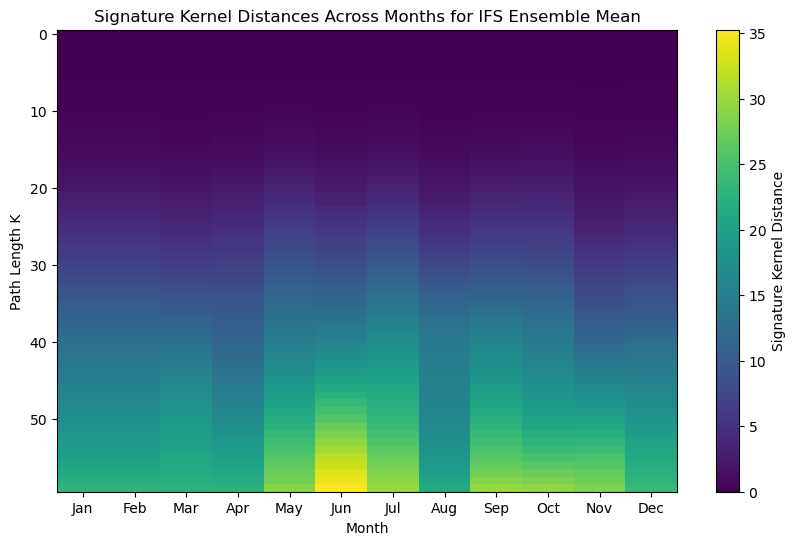

In [5]:
plt.figure(figsize=(10, 6))
plt.imshow(forecast2distancearray, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Signature Kernel Distance')
plt.xlabel('Month')
plt.ylabel('Path Length K')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Signature Kernel Distances Across Months for IFS Ensemble Mean')
plt.show()


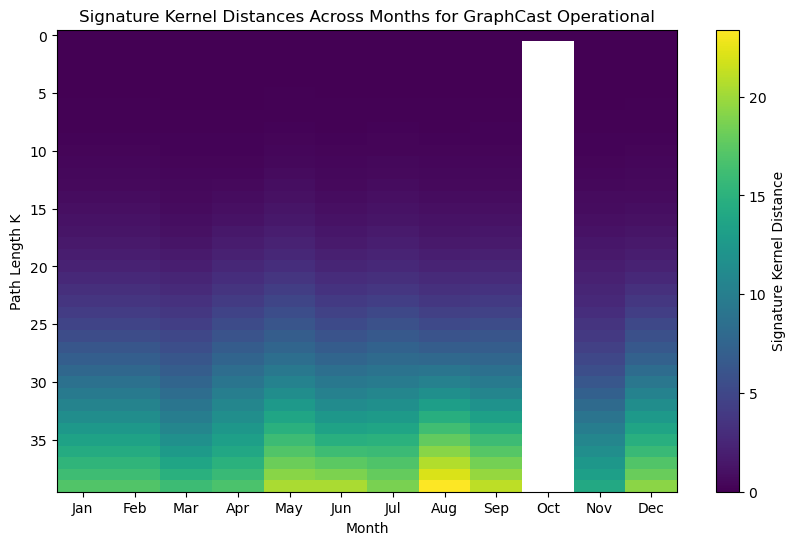

In [6]:
plt.figure(figsize=(10, 6))
plt.imshow(forecast9distancearray, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Signature Kernel Distance')
plt.xlabel('Month')
plt.ylabel('Path Length K')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Signature Kernel Distances Across Months for GraphCast Operational')
plt.show()

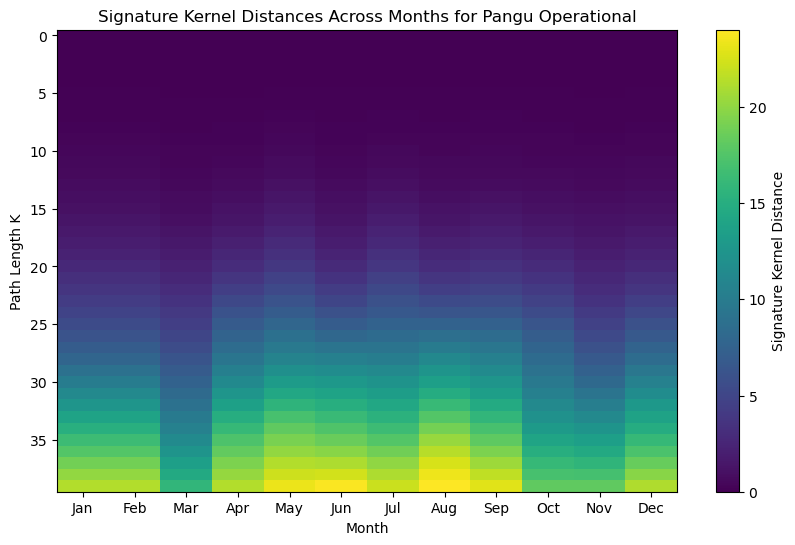

In [7]:
plt.figure(figsize=(10, 6))
plt.imshow(forecast7distancearray, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Signature Kernel Distance')
plt.xlabel('Month')
plt.ylabel('Path Length K')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Signature Kernel Distances Across Months for Pangu Operational')
plt.show()


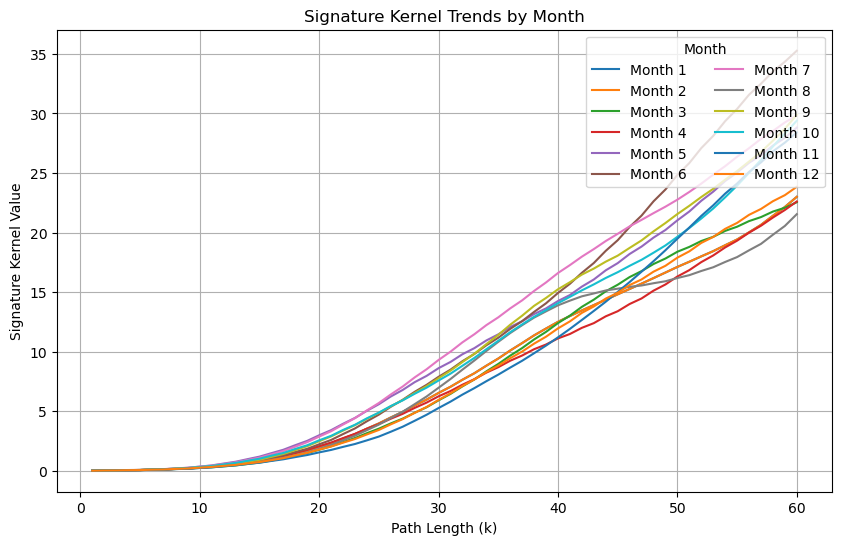

In [45]:
plt.figure(figsize=(10, 6))
for month in range(12):
    plt.plot(range(1, 61), forecast2distancearray[:, month], label=f'Month {month + 1}')

plt.xlabel('Path Length (k)')
plt.ylabel('Signature Kernel Value')
plt.title('Signature Kernel Trends by Month')
plt.legend(title='Month', loc='upper right', ncol=2)
plt.grid(True)
plt.show()

In [27]:
forecast9distancearray.shape

(40, 12)

In [11]:
for monthval in range(12):
    print(monthval)

0
1
2
3
4
5
6
7
8
9
10
11


In [ ]:
newdistance2largerzero = fu.workflowfullparallelmonthly(observations240121, forecast2largerzero, days = 5, lag = 60, zero = 1, month = monthval)
newdistance3largerzero = fu.workflowfullparallelmonthly(observations240121, forecast3largerzero, days = 5, lag = 40, zero = 1, month = monthval)
newdistance4largerzero = fu.workflowfullparallelmonthly(observations240121, forecast4largerzero, days = 5, lag = 30, zero = 1, month = monthval)
newdistance5largerzero = fu.workflowfullparallelmonthly(observations240121, forecast5largerzero, days = 5, lag = 40, zero = 1, month = monthval)

In [ ]:
newdistance6largerzero = fu.workflowfulladjusted(observations240121, forecast6larger, days = 10, lag = 40, zero = 1, month = monthval)

In [ ]:

newpk7largerzero, pkarraylatfull7largerzero, newdistance7largerzero,score7largerzero = workflowfulladjusted(observations240121, forecast7larger, days = 10, lag = 40, zero = 1)

In [ ]:

newpk8largerzero, pkarraylatfull8largerzero, newdistance8largerzero,score8largerzero = workflowfulladjusted(observations240121, forecast8larger, days = 10, lag = 40, zero = 1)

In [ ]:

newpk9largerzero, pkarraylatfull9largerzero, newdistance9largerzero,score9largerzero = workflowfulladjusted(observations240121, forecast9larger, days = 10, lag = 40, zero = 1)

In [ ]:
newpk11largerzero, pkarraylatfull11largerzero, newdistance11largerzero,score11largerzero = workflowfulladjusted(observations240121, forecast11larger, days = 10, lag = 60, zero = 1)

In [ ]:
modellist = [newdistance2largerzero,newdistance3largerzero,newdistance4largerzero,newdistance5largerzero,newdistance6largerzero,newdistance7largerzero,newdistance8largerzero,newdistance9largerzero,newdistance11largerzero]
Models = ["ENS mean", "IFS HRES", "ERA 5", "GNN","Pangu", "Pangu Op", "GraphCast", "GraphCast Op", "Fuxi"]
plt.figure(figsize=(10, 6))
# Iterate through each of the 50 models (columns in the array)
for model_index in range(len(Models)):
    marker_style = 'o' if model_index < Models.index("Pangu") else '^'
    plt.scatter(
        np.arange(modellist[model_index][1:].shape[0])+1,  # Time steps (x-axis)
        modellist[model_index][1:],     # Model predictions (y-axis)
        label=f'{Models[model_index]}',
        alpha=0.7,                # Adjust transparency
        s=10,                       # Size of the dots
        marker=marker_style  
    )
    plt.plot(np.arange(modellist[model_index][1:].shape[0])+1, modellist[model_index][1:], alpha=1)

plt.title('Distance for 9 Models on 1 day of Initialisations (Lat W.) (In. Scaled by D.) (240x121 Res.) (Zero Corr.)')
plt.xlabel('Length of Path K')
plt.ylabel('Distance')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()
    
    